In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load result data set from exercise 2
data = np.load("fashion_mnist_garments.npz")

x_garments = data["x_garments"]
y_garments = data["y_garments"]
x_others = data["x_others"]
y_others = data["y_others"]

print(f"x_garments shape: {x_garments.shape}", f"\ny_garments shape: {y_garments.shape}")

x_garments shape: (35000, 28, 28) 
y_garments shape: (35000,)


In [5]:
labels_garments = np.ones((len(x_garments), 1))
labels_others = np.zeros((len(x_others), 1))

all_x = np.concatenate([x_garments, x_others], axis=0) 
all_y = np.concatenate([labels_garments, labels_others], axis=0)

print(all_x.shape)

(70000, 28, 28)


In [6]:
x_tensor = torch.from_numpy(all_x).float()
y_tensor = torch.from_numpy(all_y).float()

print(f"x_tensor shape: {x_tensor.shape}", f"\ny_tensor shape: {y_tensor.shape}")

x_tensor shape: torch.Size([70000, 28, 28]) 
y_tensor shape: torch.Size([70000, 1])


In [7]:
dataset = TensorDataset(x_tensor,y_tensor)
train = DataLoader(dataset, batch_size=128, shuffle=True)

In [8]:
def create_classifier():
    model = nn.Sequential(
        # flatten the 28x28 images into 784 element vectors
        nn.Flatten(),
        # funnel strategy of 3 hidden layers
        nn.Linear(in_features=784, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=1),
        nn.Sigmoid()
    )

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer    

classifier, loss_fn, optimizer = create_classifier()
print(classifier)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=1, bias=True)
  (8): Sigmoid()
)


NameError: name 'torch_directml' is not defined

In [10]:
# --- Re-defining the Trainer to accept the 'device' argument ---
def train_model(model, loader, loss_fn, opt, epochs):
    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for x, y in loader:
            # Move data to the AMD GPU (DirectML)
            opt.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            opt.step()
            running_loss += loss.item()

        # Calculate average loss for this epoch
        avg_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}/{epochs} | Average Training Loss: {avg_loss:.4f}")
        losses.append(avg_loss)
        
    return losses

In [11]:

epochs = 30
losses = train_model(
    model= classifier,
    loader = train,
    loss_fn = loss_fn,
    epochs = epochs,
    opt = optimizer
)



Epoch 1/30 | Average Training Loss: 0.0192
Epoch 2/30 | Average Training Loss: 0.0106
Epoch 3/30 | Average Training Loss: 0.0083
Epoch 4/30 | Average Training Loss: 0.0078
Epoch 5/30 | Average Training Loss: 0.0071
Epoch 6/30 | Average Training Loss: 0.0062
Epoch 7/30 | Average Training Loss: 0.0058
Epoch 8/30 | Average Training Loss: 0.0056
Epoch 9/30 | Average Training Loss: 0.0050
Epoch 10/30 | Average Training Loss: 0.0048
Epoch 11/30 | Average Training Loss: 0.0043
Epoch 12/30 | Average Training Loss: 0.0041
Epoch 13/30 | Average Training Loss: 0.0039
Epoch 14/30 | Average Training Loss: 0.0037
Epoch 15/30 | Average Training Loss: 0.0034
Epoch 16/30 | Average Training Loss: 0.0033
Epoch 17/30 | Average Training Loss: 0.0032
Epoch 18/30 | Average Training Loss: 0.0033
Epoch 19/30 | Average Training Loss: 0.0029
Epoch 20/30 | Average Training Loss: 0.0028
Epoch 21/30 | Average Training Loss: 0.0027
Epoch 22/30 | Average Training Loss: 0.0027
Epoch 23/30 | Average Training Loss: 0.00

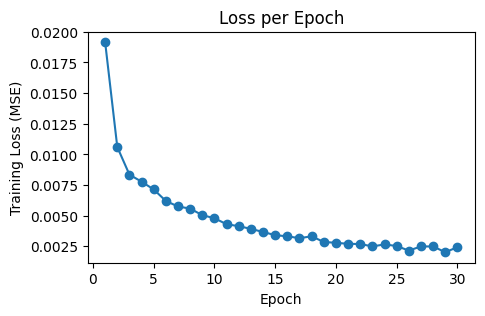

In [12]:
plt.figure(figsize=(5,3))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Loss per Epoch')
plt.grid(False) # Using grid(False) to match help notebook style
plt.show()